# OCR tables and parse the output

In this tutorial, we will illustrate how easily the `layoutparser` APIs can be used for  

1. Recognizing texts in images and store the results with the specified OCR engine
2. Postprocessing of the textual results to create structured data 


In [1]:
import layoutparser as lp 

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import cv2

## Initiate Tesseract OCR engine and check the image 

Currently, `layoutparser` supports two types of OCR engines: Google Cloud Vision and Tesseract OCR engine. And we are going to provide more support in the future. In this tutorial, we will use the Tesseract OCR engine as an example.

In [2]:
ocr_agent = lp.TesseractAgent(languages='eng')

The `language_hints` tells the GCV which langeuage shall be used for OCRing. For a detailed explanation, please check [here](https://cloud.google.com/vision/docs/languages).

The `example-table` is a scan with complicated table structures from https://stacks.cdc.gov/view/cdc/42482/. 

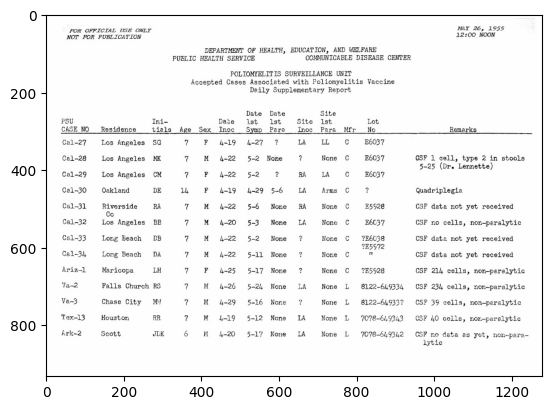

In [3]:
image = cv2.imread('data/example-table.jpeg')
plt.imshow(image);

## Load images and send for OCR


The `ocr_agent.detect` method can take the image array, or simply the path of the image, for OCR. By default it will return the text in the image, i.e., `text = ocr_agent.detect(image)`. 

However, as the layout is complex, the text information is not enough: we would like to directly analyze the response from GCV Engine. We can set the `return_response` to `True`. This feature is also supported for other OCR Engines like `TesseractOCRAgent`.

In [4]:
res = ocr_agent.detect(image, return_response=True)

# Alternative
# res = ocr_agent.detect('data/example-table.jpeg', return_response=True) 

## Parse the OCR output and visualize the layout

As defined in tesseract OCR, to retrieve the layout that was detected

1 . gather_data

    To support better user control, Tesseract also provides the 
    `gather_data` output, where it returns the hierarchical 
    structure of the output text. To process this output, we provide 
    the `ocr_agent.gather_data function to aggregate 
    the texts of the given aggregation level. 
    
    There are 5 levels specified in `TesseractFeatureType`, namely: `PAGE`, 
    `BLOCK`, `PARA`, `LINE`, `WORD`.

In [7]:
layout = ocr_agent.gather_data(res, agg_level=lp.TesseractFeatureType.WORD)
    # collect all the layout elements of the `WORD` level
# Gather all the text data into a list
texts = [b.text for b in layout]

And we can use the `draw_box` or `draw_text` functions to quickly visualize the detected layout and text information.


These functions are highly customizable. You can change styles of the drawn boxes and texts easily. Please check the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/visualization.html#layoutparser.visualization.draw_text) for the detailed explanation of the configurable parameters. 

As shown below, the `draw_text` function generates a visualization that:

1. it draws the detected layout with text on the left side and shows the original image on the right canvas for comparison.
2. on the text canvas (left), it also draws a red bounding box for each text region.

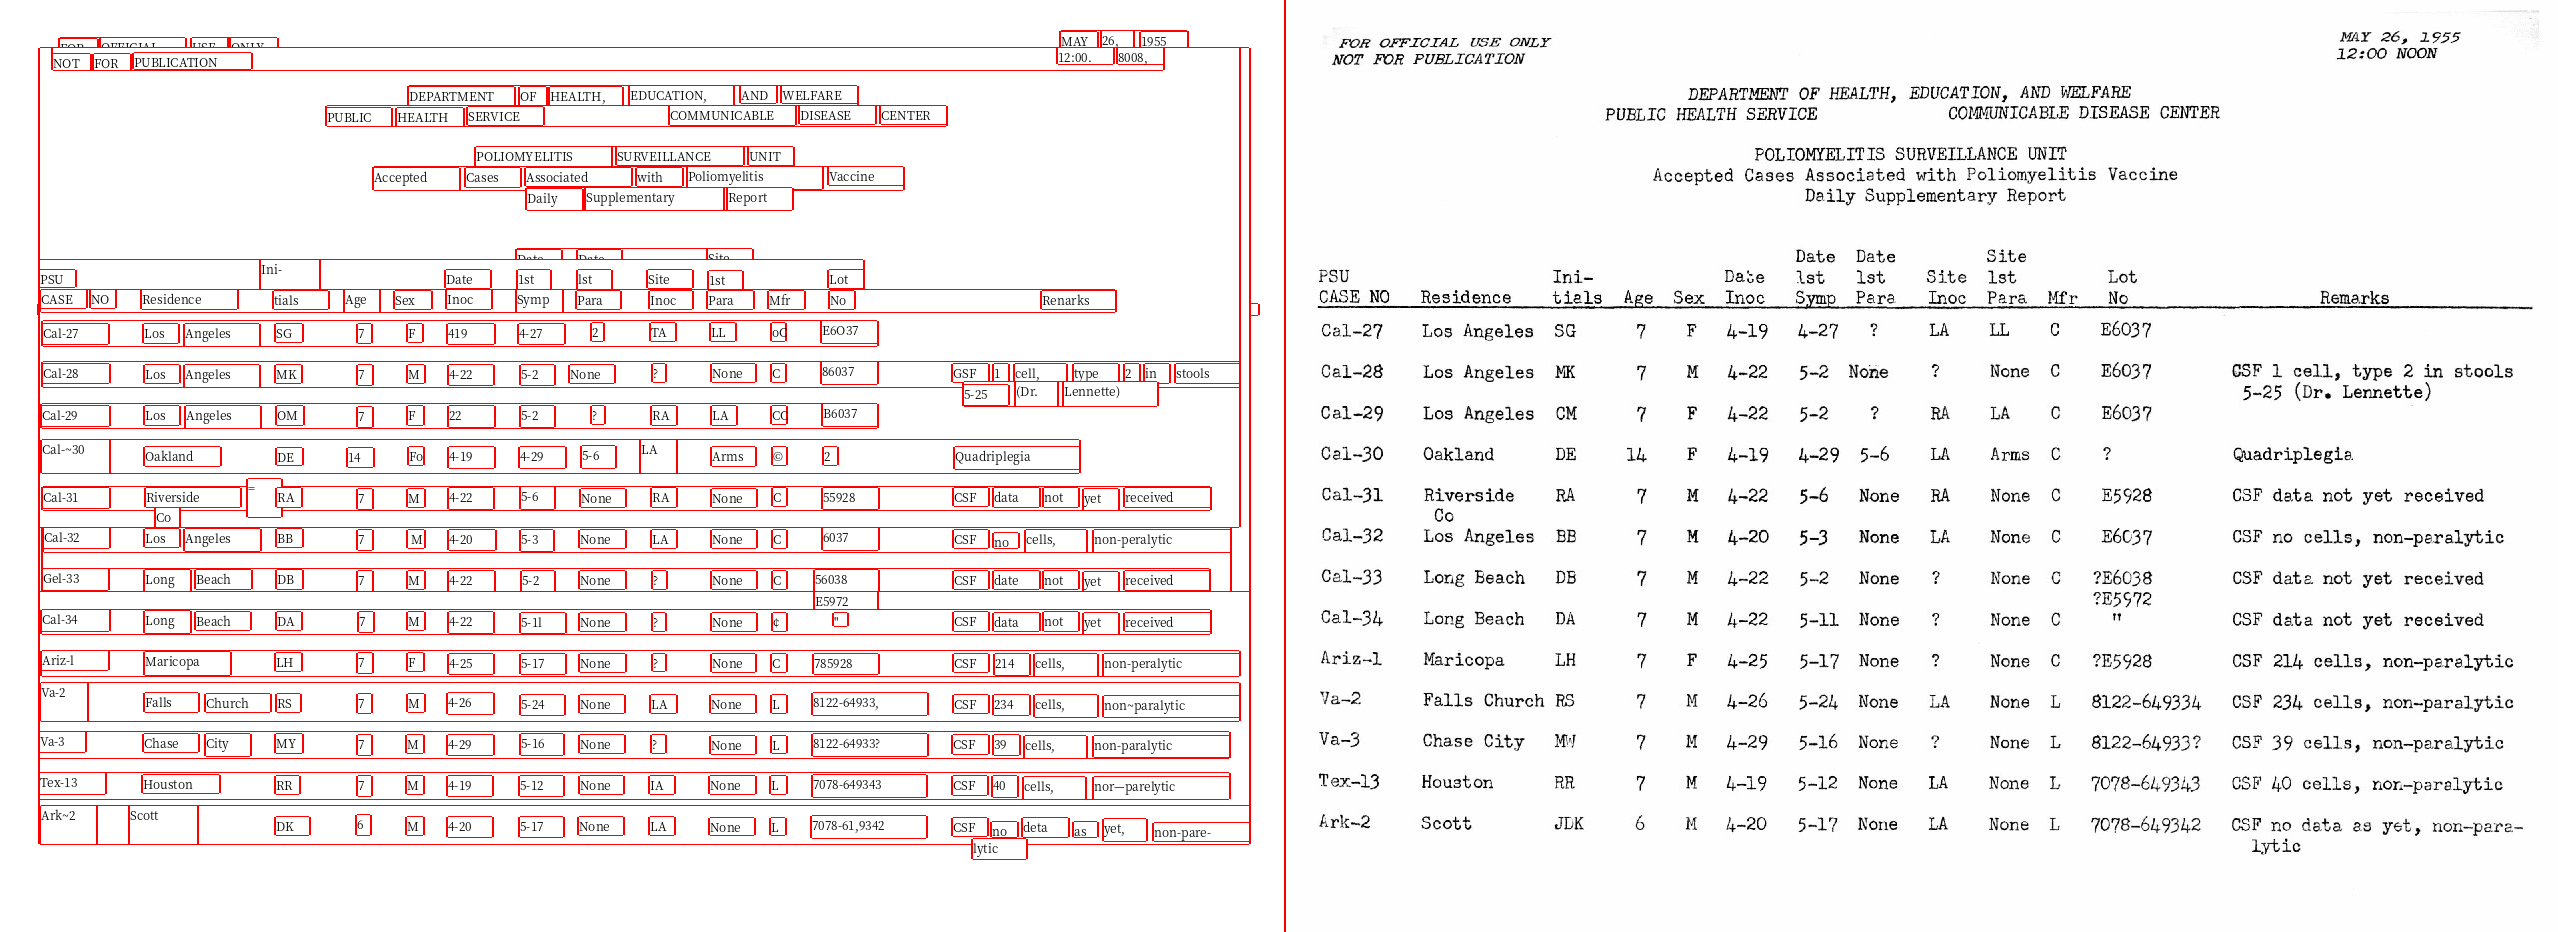

In [10]:
lp.draw_text(image, layout, font_size=12, with_box_on_text=True,
             text_box_width=4)

## Filter the returned text blocks 

We find the coordinates of residence column are in the range of $y\in(300,833)$ and $x\in(132, 264)$. The `layout.filter_by` function can be used to fetch the texts in the region. 

Note: As the OCR engine usually does not provide advanced functions like table detection, the coordinates are found manually by using some image inspecting tools like GIMP.

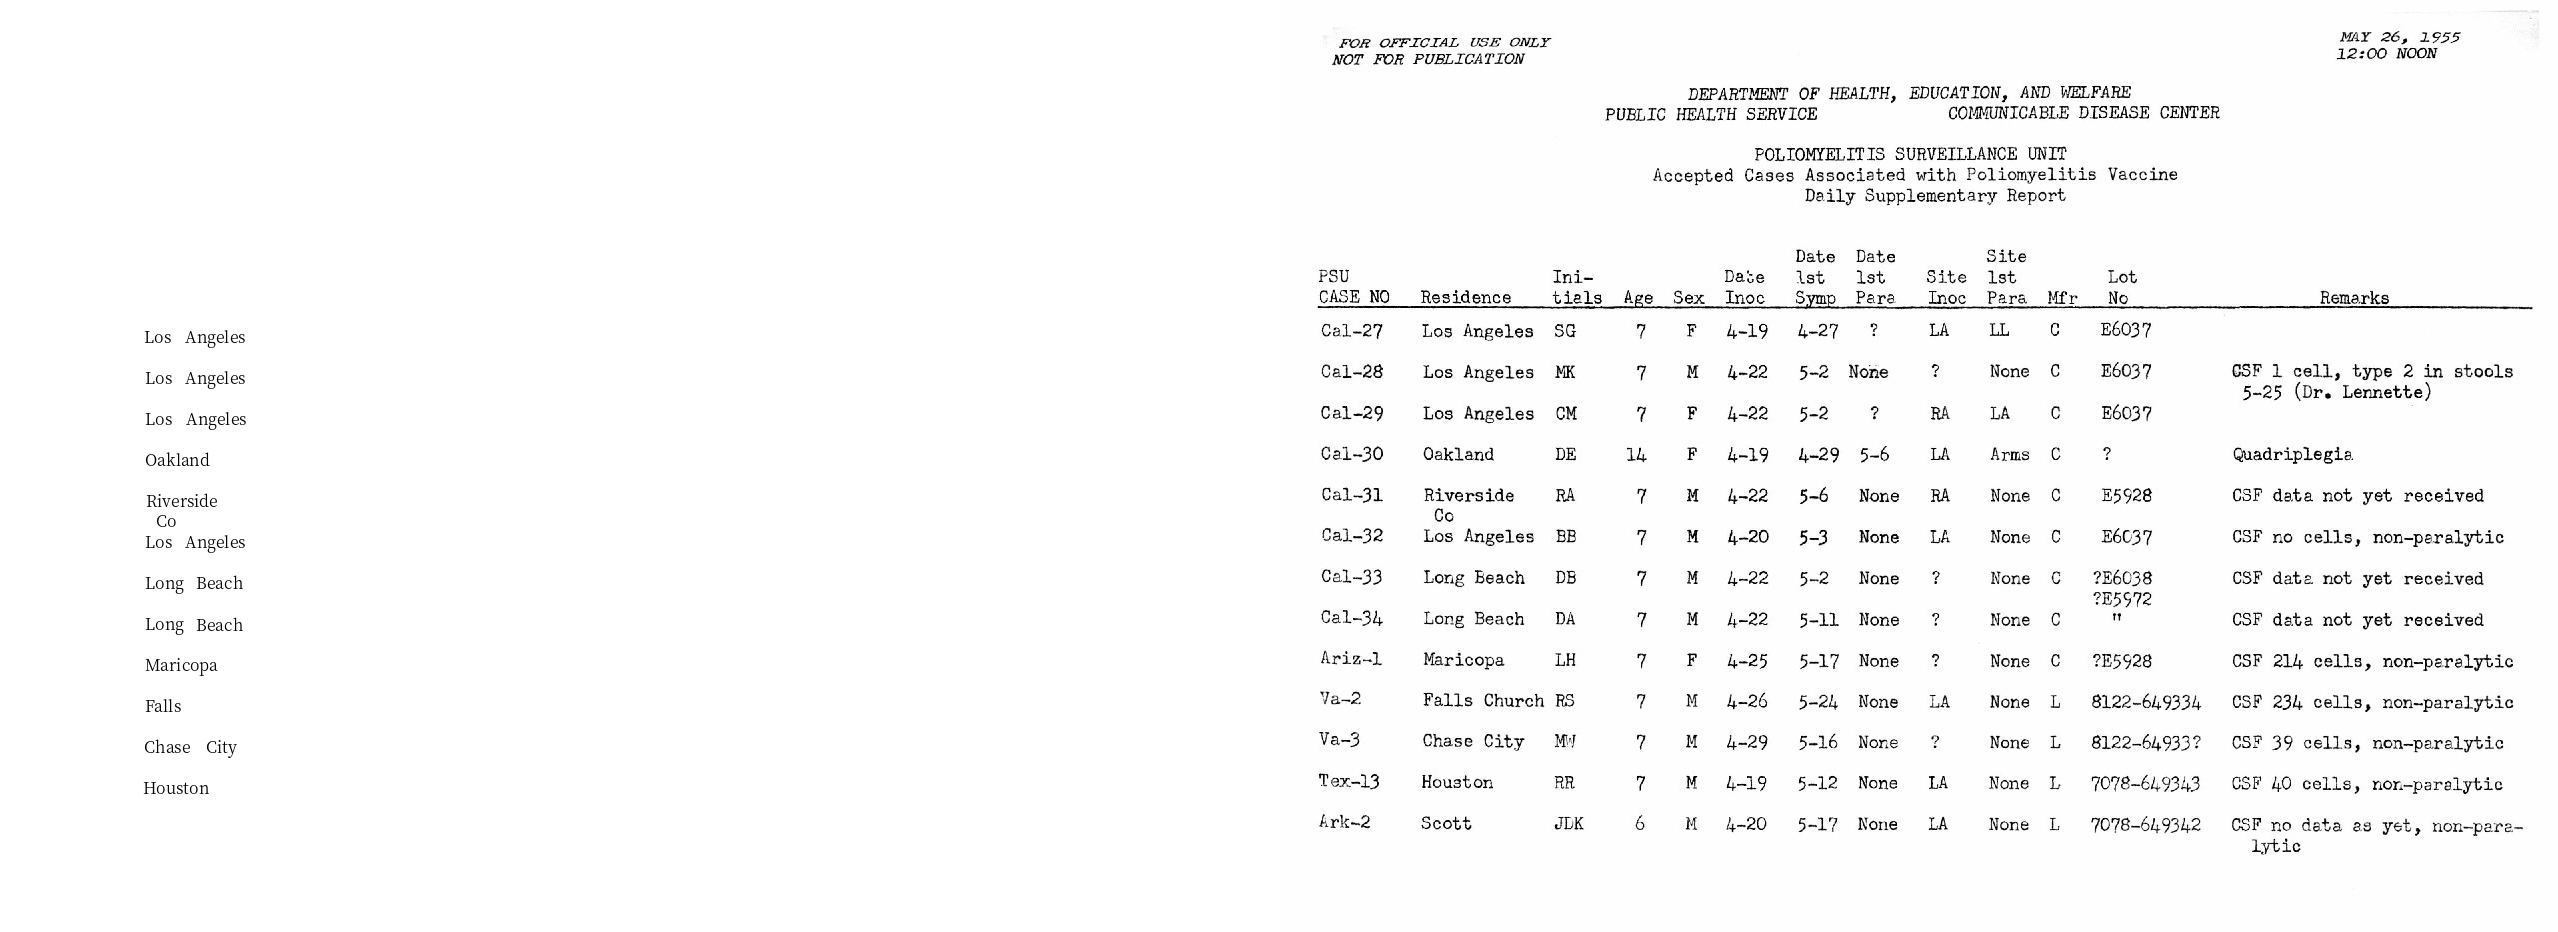

In [11]:
filtered_residence = layout.filter_by(
    lp.Rectangle(x_1=132, y_1=300, x_2=264, y_2=840)
)
lp.draw_text(image, filtered_residence, font_size=16)

And similarily, we can do that for the `lot_number` column. As sometimes there could be irregularities in the layout as well as the OCR outputs, the `layout.filter_by` function also supports a `soft_margin` argument to handle this issue and generate more robust outputs. 


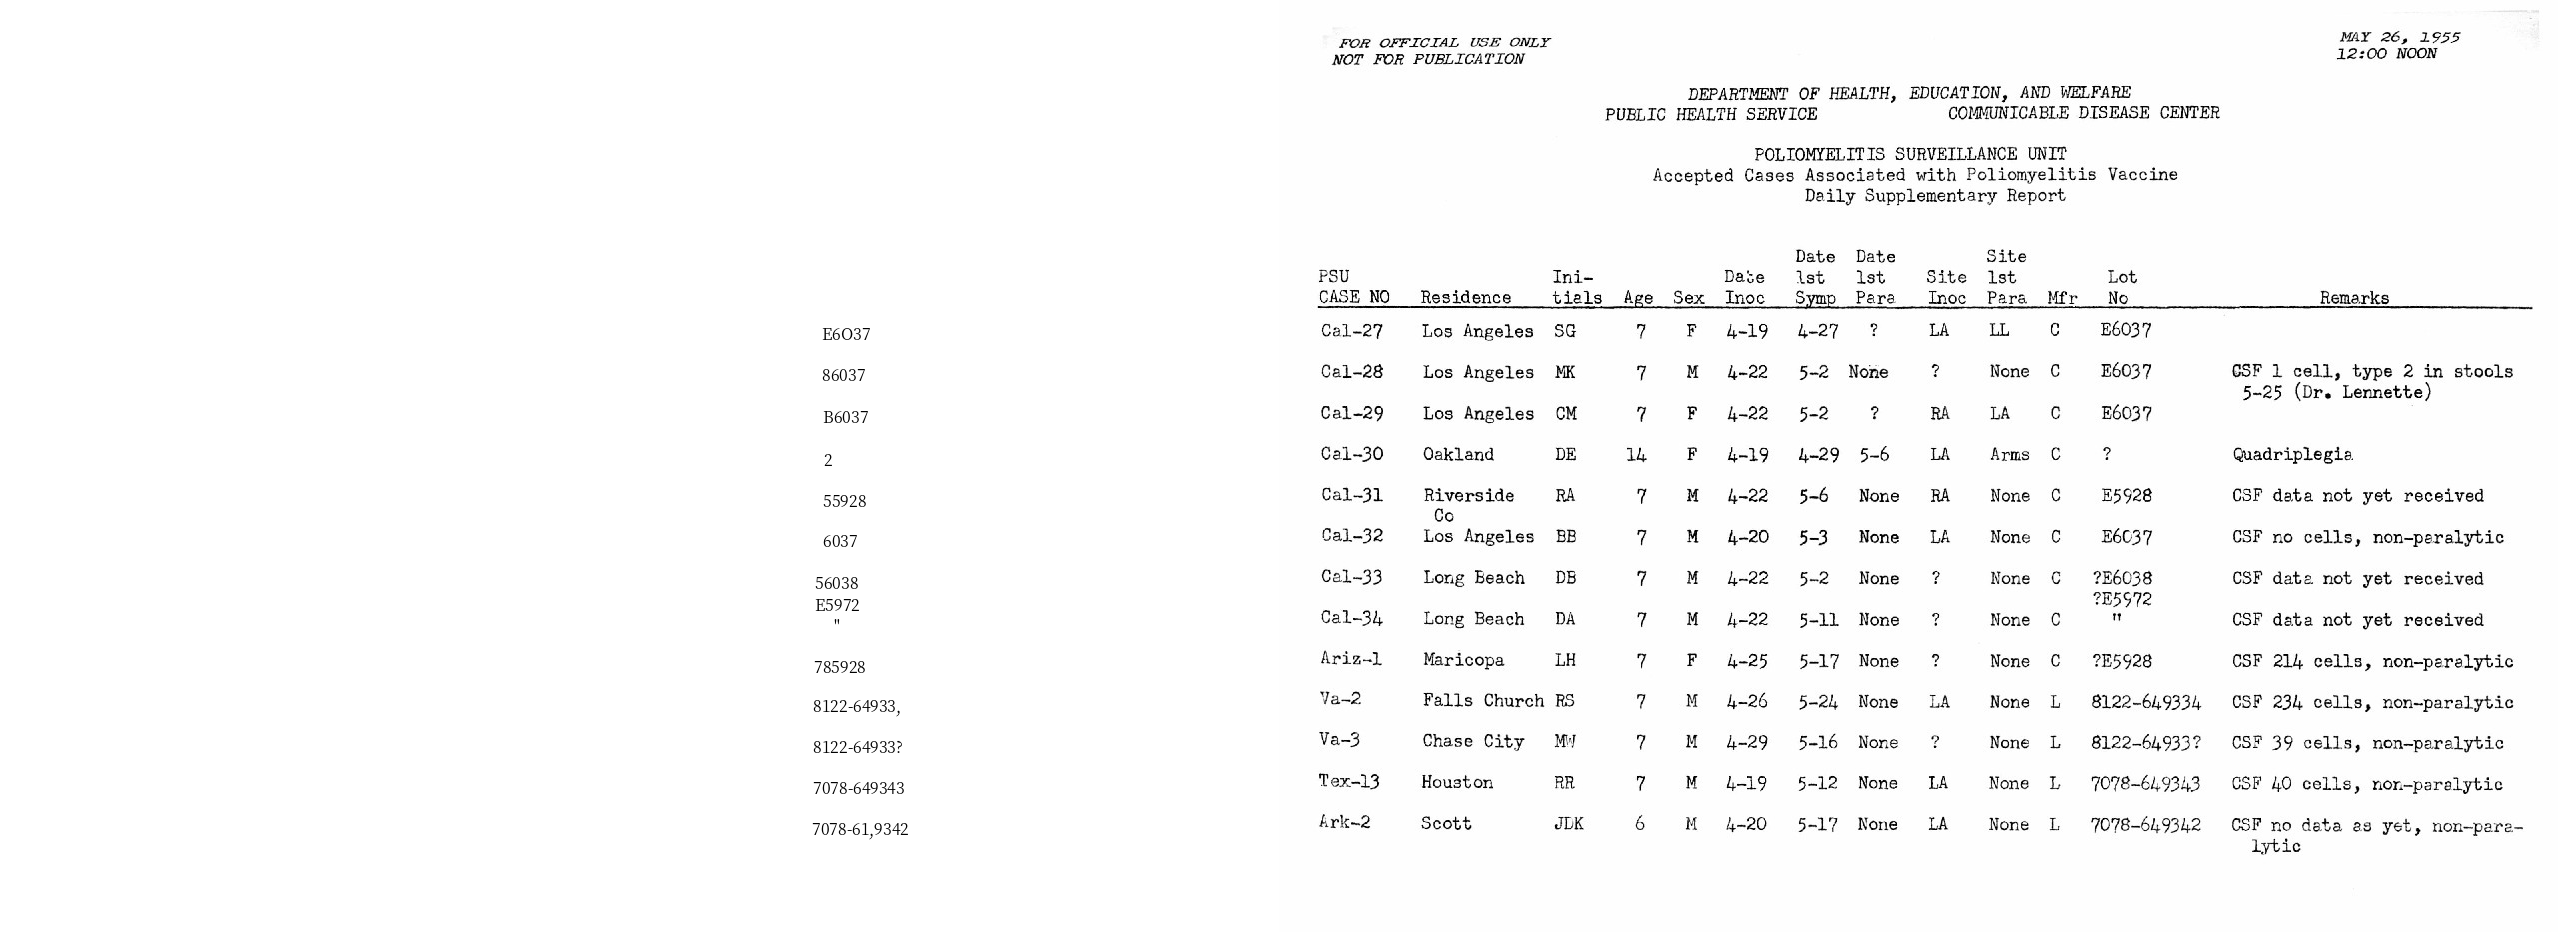

In [12]:
filter_lotno = layout.filter_by(
    lp.Rectangle(x_1=810, y_1=300, x_2=910, y_2=840),
    soft_margin = {"left":10, "right":20} # Without it, the last 4 rows could not be included
)
lp.draw_text(image, filter_lotno, font_size=16)

### Group Rows based on hard-coded parameteres

As there are 13 rows, we can iterate the rows and fetch the row-based information:

In [13]:
y_0 = 307
n_rows = 13
height = 41
y_1 = y_0+n_rows*height

row = []
for y in range(y_0, y_1, height):
    
    interval = lp.Interval(y,y+height, axis='y')
    residence_row = filtered_residence.\
        filter_by(interval).\
        get_texts()

    lotno_row = filter_lotno.\
        filter_by(interval).\
        get_texts()
    
    row.append([''.join(residence_row), ''.join(lotno_row)])

In [14]:
row

[['LosAngeles', 'E6O37'],
 ['LosAngeles', '86037'],
 ['LosAngeles', 'B6037'],
 ['Oakland', '2'],
 ['Riverside', '55928'],
 ['LosAngeles', '6037'],
 ['LongBeach', '56038'],
 ['LongBeach', '"'],
 ['Maricopa', '785928'],
 ['Falls', '8122-64933,'],
 ['ChaseCity', '8122-64933?'],
 ['Houston', '7078-649343'],
 ['', '7078-61,9342']]

### An Alternative Method - Adaptive Grouping lines based on distances 

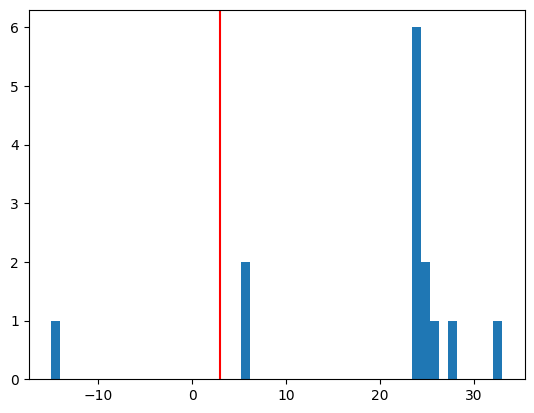

In [15]:
blocks = filter_lotno

blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    # Sort the blocks vertically from top to bottom 
distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])
    # Calculate the distances: 
    # y coord for the upper edge of the bottom block - 
    #   y coord for the bottom edge of the upper block
    # And convert to np array for easier post processing
plt.hist(distances, bins=50);
plt.axvline(x=3, color='r');
    # Let's have some visualization 

According to the distance distribution plot, as well as the OCR results visualization, we can conclude:

- For the negative distances, it's because there are texts in the same line, e.g., "Los Angeles"
- For the small distances (indicated by the red line in the figure), they are texts in the same table row as the previous one 
- For larger distances, they are generated from texts pairs of different rows 

In [16]:
distance_th = 0

distances = np.append([0], distances) # Append a placeholder for the first word
block_group = (distances>distance_th).cumsum() # Create a block_group based on the distance threshold 

block_group

array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  8,  9, 10, 11, 12, 13])

In [17]:
# Group the blocks by the block_group mask 
grouped_blocks = [[] for i in range(max(block_group)+1)]
for i, block in zip(block_group, blocks):
    grouped_blocks[i].append(block) 

Finally let's create a function for them

In [18]:
def group_blocks_by_distance(blocks, distance_th):

    blocks = sorted(blocks, key = lambda x: x.coordinates[1])
    distances = np.array([b2.coordinates[1] - b1.coordinates[3] for (b1, b2) in zip(blocks, blocks[1:])])

    distances = np.append([0], distances)
    block_group = (distances>distance_th).cumsum()

    grouped_blocks = [lp.Layout([]) for i in range(max(block_group)+1)]
    for i, block in zip(block_group, blocks):
        grouped_blocks[i].append(block) 
        
    return grouped_blocks

In [19]:
A = group_blocks_by_distance(filtered_residence, 5)
B = group_blocks_by_distance(filter_lotno, 10) 

# And finally we combine the outputs 
height_th = 30
idxA, idxB = 0, 0

result = []
while idxA < len(A) and idxB < len(B):
    ay = A[idxA][0].coordinates[1]
    by = B[idxB][0].coordinates[1]
    ares, bres = ''.join(A[idxA].get_texts()), ''.join(B[idxB].get_texts())
    if abs(ay - by) < height_th:
        idxA += 1; idxB += 1
    elif ay < by:
        idxA += 1; bres = ''
    else: 
        idxB += 1; ares = ''
    result.append([ares, bres])
    
result

[['LosAngeles', 'E6O37'],
 ['LosAngeles', '86037'],
 ['LosAngeles', 'B6037'],
 ['Oakland', '2'],
 ['Riverside', '55928'],
 ['Co', '6037'],
 ['LosAngeles', ''],
 ['LongBeach', '56038E5972"'],
 ['LongBeach', ''],
 ['Maricopa', '785928'],
 ['Falls', '8122-64933,'],
 ['ChaseCity', '8122-64933?'],
 ['Houston', '7078-649343']]

As we can find, there are mistakes in the 5th and 6h row - `Riverside Co` and `LosAngeles` are wrongly combined. This is because the extra row `co` disrupted the row segmentation algorithm. 

## Save the results as a table

In [20]:
df = pd.DataFrame(row, columns=['residence', 'lot no'])
df

,residence,lot no
0,LosAngeles,E6O37
1,LosAngeles,86037
2,LosAngeles,B6037
3,Oakland,2
4,Riverside,55928
5,LosAngeles,6037
6,LongBeach,56038
7,LongBeach,""""
8,Maricopa,785928
9,Falls,"8122-64933,"


In [17]:
df.to_csv('./data/ocred-example-table.csv', index=None)